c:\users\rohin gupta\appdata\local\programs\python\python37\lib\site-packages\keras\utils\conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


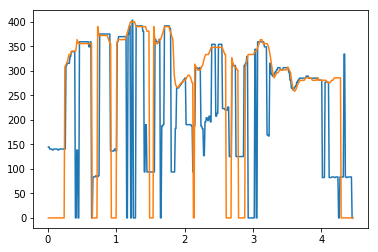

RPA- 0.5911602209944752
RCA- 0.6215469613259669


In [8]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from keras.models import load_model
import mir_eval
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense, Activation

gamma=[0.24,0.6,1]
count=0
raw_pitch=0
chroma=0
oa=0
for g in os.listdir("MIR-1K_for_MIREX/Wavfile"):
    if(count!=999):
        count+=1
        continue
    count+=1
    y,sr=librosa.load("MIR-1K_for_MIREX/Wavfile"+'/'+ g,sr=16000)
    X=librosa.core.stft(y,n_fft=8000,window='blackmanharris',hop_length=320,win_length=2048)
    X=np.abs(X)
#print(X.shape)
#plt.figure(figsize=(10,10))
#Nyticks = 10
#ks      = np.linspace(0,X.shape[0],Nyticks)
#ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
#plt.yticks(ks)
#plt.ylabel("Frequency (Hz)")

    Z0=np.power(X,gamma[0])
#plt.imshow(Z0[:400])
#plt.show()

    Z1=np.zeros(Z0.shape)
    Z1=np.real(np.fft.ifft(X,axis=0))/np.sqrt(8000)
    qc=16
    Z1[Z1<0]=0
    Z1[:qc,:]=0
#Z1[-qc:,:]=0
    Z1=np.power(Z1,gamma[1])

    Z2=np.zeros(Z0.shape)
    Z2=np.real(np.fft.fft(Z1,axis=0))/np.sqrt(8000)
    kc=40
    Z2[Z2<0]=0
    Z2[:kc,:]=0
#Z2[-kc:,:]=0
    Z2=np.power(Z2,gamma[2])

    highest_freq_index=501
    Z0=Z0[:highest_freq_index]
    Z2=Z2[:highest_freq_index]
#plt.imshow(Z2)
#plt.show()
    highest_qfreq_index=201
    Z1=Z1[:highest_qfreq_index]

    freq_bin=[]
    start_freq=80
    current_freq=80
    m=1
    while current_freq<1000:
        current_freq=80*np.power(2,(m-1)/48)
        if(current_freq<1000):
            freq_bin.append(current_freq)
        m+=1

    freq_transformation=np.zeros((len(freq_bin),501))
    for i in range(1,len(freq_bin)-1):
        l=int(round(freq_bin[i-1]/2))
        r=int(round(freq_bin[i+1]/2 + 1))
    #print(l,r)
        if l >= r-1:
            freq_transformation[i, l] = 1
        else:
            for j in range(l, r):
                f=j*(2)
                if f > freq_bin[i-1] and f < freq_bin[i]:
                    freq_transformation[i, j] = (f - freq_bin[i-1]) / (freq_bin[i] - freq_bin[i-1])
                elif f > freq_bin[i] and f < freq_bin[i+1]:
                    freq_transformation[i, j] = (freq_bin[i + 1] - f) / (freq_bin[i + 1] - freq_bin[i])
    Z2=np.dot(freq_transformation,Z2)
    Z0=np.dot(freq_transformation,Z0)
#print(freq_bin)
    freq_transformation=np.zeros((len(freq_bin),201))
    for i in range(1,len(freq_bin)-1):
        l=int(round(16000/freq_bin[i-1]))
        r=int(round(16000/freq_bin[i+1]))
    #print(l,r)
        if(l>=r-1):
            freq_transformation[i,l]=1
            continue
        for j in range(l,r):
            q=16000/j
            if q > freq_bin[i-1] and q < freq_bin[i]:
                freq_transformation[i, j] = (q - freq_bin[i-1])/(freq_bin[i] - freq_bin[i-1])
            elif q > freq_bin[i] and q < freq_bin[i+1]:
                freq_transformation[i, j] = (freq_bin[i + 1] - q) / (freq_bin[i + 1] - freq_bin[i])
    Z1=np.dot(freq_transformation,Z1)

    ans=Z1*Z2
    #plt.imshow(ans)
    #plt.title('Refined Spectogram')
    
    
    M, N = np.shape(ans)    
    half_ps = int(np.floor(float(25)/2))
    ans = np.append(np.zeros([M, half_ps]), ans, axis = 1)
    ans = np.append(ans, np.zeros([M, half_ps]), axis = 1)
    ans = np.append(ans, np.zeros([half_ps, N+2*half_ps]), axis = 0)
    ans = np.append(np.zeros([half_ps, N+2*half_ps]), ans, axis = 0)
    M, N = np.shape(ans)
    data = np.zeros([300000, 25, 25])
    mapping = np.zeros([300000, 2])
    counter = 0
    for index in range(half_ps,N-half_ps):
        pre = ans[1:M - 1,index] - ans[0:M - 2,index]
        pre[pre < 0] = 0
        pre[pre > 0] = 1
        post = ans[1:M - 1,index] - ans[2:,index]
        post[post < 0] = 0
        post[post > 0] = 1
        mask = pre * post
        ext_mask = np.append([0], mask, axis=0)
        ext_mask = np.append(ext_mask, [0], axis=0)
        locs = np.where(ext_mask==1)
        locs = locs[0]
        for i in range(0, len(locs)):
            if locs[i] >= half_ps and locs[i] < M - half_ps and counter<300000 and ans[locs[i],index] > 0.5*max(ans[:,index]):
                patch = ans[np.ix_(range(locs[i]-half_ps, locs[i]+half_ps+1), range(index-half_ps, index+half_ps+1))]
                patch = patch.reshape(1, 25, 25)
                data[counter,:,:] = patch
                mapping[counter,:] = np.array([[locs[i], index]])
                counter = counter + 1
    data = data[:counter-1,:,:]
    mapping = mapping[:counter-1,:]
    ans = ans[:M-half_ps,:]
    ans = ans[half_ps:,:]
    ans = ans[:,:N-half_ps]
    ans = ans[:,half_ps:]
    
    
    data = data.reshape(data.shape[0], 25, 25, 1)
    model = load_model('model')
    pred  = model.predict(data)
    N=ans.shape[1]+25
    PredContour=np.zeros(N)
    pred=pred[:,0]

#print(pred.shape)
    pred_idx = np.where(pred>0.5)
    MM=mapping[pred_idx[0],:]
    pred_prob = pred[pred_idx[0]]
    MM = np.append(MM, np.reshape(pred_prob, [len(pred_prob),1]), axis=1)
#print(MM.shape)
#MM = MM[MM[:,1].argsort()]
    for index in range(12, N-12):
        Candidate = MM[np.where(MM[:,1]==index)[0],:]
        if(Candidate.shape[0]>=1):
        #final = np.where(Candidate[:,2]==np.max(Candidate[:,2]))
        #final=final[0]
        #final = final.astype('int')
        #if(Candidate[0][2]>0.993):
            PredContour[index] = Candidate[0,0]
    PredContour = PredContour[range(12, N-12)]
    for i in range(len(PredContour)):
        if(PredContour[i]>1):
            PredContour[i]=freq_bin[int(PredContour[i])-12]
            if(PredContour[i]>500):
            #PredContour[i]=PredContour[i-1]
                PredContour[i]=0
    Fin=np.zeros(len(PredContour)*2)
    for i in range(len(PredContour)):
        Fin[2*i]=PredContour[i]
        Fin[2*i+1]=PredContour[i]
#print(PredContour)

    file1=open('MIR-1K_for_MIREX/PitchLabel' + '/' + g[:-4] + '.pv'  ,'r')
    a=[]
    b=[]
    for line in file1:
        fields=line.split()
        a.append(float(fields[0]))
        b.append(float(fields[1]))
#plt.figure(figsize=(10,10))
    x=np.linspace(a[0],a[-1],num=len(Fin))

#while (len(a)<Fin.shape[0]):
#    a.append(float(0))
#    b.append(float(0))
#print(x.shape)
#print(len(a))
#print(Fin.shape)
#print(len(b))
    plt.plot(x,Fin)
    plt.plot(a,b)
    plt.show()
    (ref_v, ref_c, est_v, est_c) = mir_eval.melody.to_cent_voicing(a,b,x,Fin)
    raw_pitch += mir_eval.melody.raw_pitch_accuracy(ref_v, ref_c, est_v, est_c)
    chroma+=  mir_eval.melody.raw_chroma_accuracy(ref_v, ref_c, est_v, est_c)
    oa+=mir_eval.melody.overall_accuracy(ref_v, ref_c, est_v, est_c)
    #print(count)
print("RPA-",raw_pitch)
print("RCA-",chroma)
#print(oa)

#plt.imshow(ans)
#plt.show()

Text(0.5, 1.0, 'Refined Spectogram')

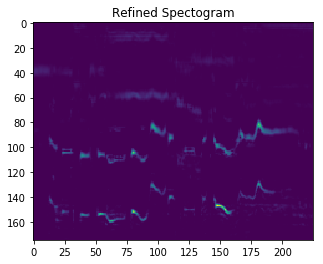

In [9]:
plt.imshow(ans)
plt.title('Refined Spectogram')